In [1]:
from site_visit import *
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from scipy.spatial import distance_matrix
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

#color_lst = px.colors.qualitative.Light24

prop_cycle = plt.rcParams['axes.prop_cycle']
color_lst = prop_cycle.by_key()['color']

color_lst = px.colors.qualitative.Light24

## Function Defs

In [57]:
#def eval_on_random(config, vocab_lsts, count_lsts):
def eval_on_random(config, spatial_data, vocab_lsts, count_lsts):
    
    #_data = [row for row in csv.DictReader(open(config['DATA']), delimiter='\t')]
    sample = []
    p = config['DEV']
    for t in range(1,7):
        for step in spatial_data[(p,str(t))]:
            if step % 450 == 0:
                sample.append({'participant': p, 'task': str(t), 'step': step, 'lemma': 'NA', 'pos': 'NA'})
                
    #sample = random.sample(_data, 10)
    #sample = [e for e in _data if e['participant'] == config['DEV']]
    #sample = sorted(sample, key=lambda e:(e['task'], int(e['step'])))
    
    sys.stderr.write("Data: %d items\n"%len(sample))

    X, y, meta = _make_raw_spatial_mats(sample, spatial_data,
                                               feat_lst=config['FEATURES'],
                                               use_objs=config['OBJS'],
                                               use_most_moving=config['MOST_MOVING'],
                                               window_size = config['WINDOW'],
                                               logdir=None)

    return X, y, meta

In [66]:
def prep_data(config, logdir):
    _data = [row for row in csv.DictReader(open(config['DATA']), delimiter='\t')]
    sys.stderr.write("Data: %d items\n"%len(_data))

    vocab_lsts, count_lsts = get_vocabs(_data, MODE=config['MODE'],
                                        K=config['K'], CUTOFF=config['CUTOFF'])
    
    #top_words = ["pick_VERB", "put_VERB", "hold_VERB", "eat_VERB"]
    top_words = get_top_words(config['POS'])
    #top_words = [w for i, w in enumerate(vocab_lsts[1])
    #             if (w.split('_')[1] == config['POS'] and count_lsts[1][i] >= 10)]
    #sorted_words = [w for w, c in sorted(zip(vocab_lsts[1], count_lsts[1]), key=lambda e:e[1], reverse=True)]
    #sorted_pos = [w for w in sorted_words if (config['POS'] in w) and (w not in top_words)]
    #top_words += sorted_pos[:15]
    
    _data = [d for d in _data if '%s_%s'%(d['lemma'], d['pos']) in top_words]
    sys.stderr.write("Filtered Data: %d items\n"%len(_data))
    
    X, y, meta = _make_raw_spatial_mats(_data, spatial_data,
                                               feat_lst=config['FEATURES'],
                                               use_objs=config['OBJS'],
                                               use_most_moving=config['MOST_MOVING'],
                                               window_size = config['WINDOW'],
                                               logdir=logdir)

    if config['MODE'] == 'random':
        rows, cols = X.shape
        X = np.random.rand(rows, cols)
    if config['MODE'] == 'oracle':
        rows, cols = X.shape
        words = sorted(list(set(y)))
        X = np.random.rand(rows, len(words))
        for i, w in enumerate(y):
            X[i, words.index(w)] = 1


    return vocab_lsts, count_lsts, top_words, X, y, meta

def filter_and_dedup(X, y, meta, top_words):
    X_filt, y_filt, m_filt = filter_mats(X, y, meta, top_words)

    dedup = []
    seen = set()
    for i, (mm, yy) in enumerate(zip(m_filt, y_filt)):
        part, task, step, steps = mm.split()
        if (part, task, yy) not in seen:
            seen.add((part, task, yy))
            dedup.append(i)

    X_filt = X_filt[dedup]
    y_filt = y_filt[dedup]
    m_filt = m_filt[dedup]
    
    return X_filt, y_filt, m_filt


In [4]:
def name_from_config(config):
    fnames = ['k', 'win'] 
    fs = ['K', 'WINDOW'] 

    return '_'.join(['%s=%s'%(fnames[i],
                              config[fs[i]]) for i in range(len(fs))])

def make_directories(config):

    make = config['LOG']
    
    # set up directories and such
    inp = config['MODE'].split('.')[0].split('/')[-1]

    inp += '_' + name_from_config(config)

    rootdir = 'spatial_eval/%s/'%inp
    
    figdir = rootdir + 'red=%s_dim=%s_sup=%s/figures'%(config['RED'],
                                                    config['DIM'], config['SUP'])
    repdir = rootdir + 'red=%s_dim=%s_sup=%s/reports'%(config['RED'],
                                                config['DIM'], config['SUP'])
    if make:
        if not os.path.exists(figdir):
            os.makedirs(figdir)
        if not os.path.exists(repdir):
            os.makedirs(repdir)
        
    return repdir, figdir

def vocab_mat_figures(outpath, nm, mat, words, mn, mx, fmt='png', save=False):
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    plt.figure(figsize=(4, 0.2*len(words)))
    sns.heatmap(mat, cmap="coolwarm_r", vmin=mn, vmax=mx)
    plt.yticks(np.arange(len(words))+0.5, words, rotation="horizontal")
    if save:
        plt.savefig('%s/agg_%s.%s'%(outpath, nm, fmt), bbox_inches='tight')
    plt.show()
    plt.clf()
    
def vocab_mat_figures_indv(outpath, tup, mn, mx, fmt='png', save=False):
    use_X, use_y, use_m = tup
    for w in set(use_y):
        idx = [i for i, u in enumerate(use_y) if u == w]
        if len(idx) == 0:
            continue
        plt.figure(figsize=(4, 0.2*len(idx)))
        sns.heatmap(use_X[idx, :], cmap="coolwarm_r", vmin=mn, vmax=mx)
        plt.title(w)
        ticks = use_m[idx]
        plt.yticks(np.arange(len(ticks))+0.5, ticks, rotation="horizontal")
        if save:
            plt.savefig('%s/%s_full.%s'%(outpath, w, fmt), bbox_inches='tight')
        plt.show()
        plt.clf()
        
def avg_mat(tup, words):
    use_X, use_y, use_m = tup
    n_obs, n_feat = use_X.shape
    mat = np.zeros((len(words), n_feat))
    for i, w in enumerate(words):
        avg = use_X[use_y == w, :].sum(axis=0)
        mat[i, :] = avg
    return mat

In [63]:
def _max_dist_change_feats(ref, mat):
    dists = distance_matrix(ref.reshape(1, -1), mat)

    max_idx = [e for e in reversed(dists[0].argsort())][0]
    mx = dists[0, max_idx]

    mxx, mxy, mxz = mat[max_idx, :]
    names = ["dist", "x", "y", "z"]
    feats = [mx, mxx, mxy, mxz]
    return feats, names

def _dist_change_feats(s, e):
    
    d = euclidean(s, e)

    names = ["dist", "x", "y", "z"]
    feats = [d] + [s[i] - e[i] for i in range(3)]
    return feats, names

def _avg_feats(span, dims):
    
    avg = span.mean(axis=0)

    names = ["%savg"%d for d in dims]
    feats = [avg[i] for i in range(len(dims))]
    return feats, names

def _var_feats(span, dims):
    
    avg = span.std(axis=0)

    names = ["%svar"%d for d in dims]
    feats = [avg[i] for i in range(len(dims))]
    return feats, names

def _dist_to_obj_feats(obj, ref):

    at_start = euclidean(obj[0], ref[0])
    at_end = euclidean(obj[-1], ref[-1])
    
    dists = np.linalg.norm(obj - ref)
    avg = dists.mean()
    
    names = ["start", "end", "mean"]
    feats = [at_start, at_end, avg]
    return feats, names

def get_features(span, all_feats, all_obj_spans, use=None):

    feats = []
    names = []
    
    # change in absoluate position, start to max
    if (use is None) or ('abs_st_mx' in use):
        px = all_feats.index('posX')
        py = all_feats.index('posY')
        pz = all_feats.index('posZ')
        fs, ns = _max_dist_change_feats(span[0, [px, py, pz]], span[:, [px, py, pz]])
        if np.isnan(fs).any():
            print("NaNs!! %s"%(' '.join(ns)), fs)
        names += ["abs_st_mx"+e for e in ns]
        feats += fs
        
    # change in absoluate position, end to max
    if (use is None) or ('abs_end_mx' in use):
        px = all_feats.index('posX')
        py = all_feats.index('posY')
        pz = all_feats.index('posZ')
        fs, ns = _max_dist_change_feats(span[-1, [px, py, pz]], span[:, [px, py, pz]])
        if np.isnan(fs).any():
            print("NaNs!! %s"%(' '.join(ns)), fs)
        names += ["abs_end_mx"+e for e in ns]
        feats += fs
    
    # change in absoluate position, start to end
    if (use is None) or ('abs_pos_se' in use):
        px = all_feats.index('posX')
        py = all_feats.index('posY')
        pz = all_feats.index('posZ')
        fs, ns = _dist_change_feats(span[0, [px, py, pz]], span[-1, [px, py, pz]])
        if np.isnan(fs).any():
            print("NaNs!! %s"%(' '.join(ns)), fs)
        names += ["abs_pos_se_"+e for e in ns]
        feats += fs
        
    # distance to the right hand
    if (use is None) or ('dist_to_rhand' in use): 
        px = all_feats.index('posX')
        py = all_feats.index('posY')
        pz = all_feats.index('posZ')
        this = span[:, [px, py, pz]]
        ref = all_obj_spans['RightHand'][:, [px, py, pz]]
        fs, ns = _dist_to_obj_feats(this, ref)
        names += ["dist_to_rhand_"+e for e in ns]
        feats += fs
        
    # distance to the left hand
    if (use is None) or ('dist_to_lhand' in use):  
        px = all_feats.index('posX')
        py = all_feats.index('posY')
        pz = all_feats.index('posZ')
        this = span[:, [px, py, pz]]
        ref = all_obj_spans['LeftHand'][:, [px, py, pz]]
        fs, ns = _dist_to_obj_feats(this, ref)
        names += ["dist_to_lhand_"+e for e in ns]
        feats += fs
    
    # change in relative position, start to max
    if (use is None) or ('rel_st_mx' in use):
        px = all_feats.index('relPosX')
        py = all_feats.index('relPosY')
        pz = all_feats.index('relPosZ')
        fs, ns = _max_dist_change_feats(span[0, [px, py, pz]], span[:, [px, py, pz]])
        if np.isnan(fs).any():
            print("NaNs!! %s"%(' '.join(ns)), fs)
        names += ["rel_st_mx"+e for e in ns]
        feats += fs
        
    # change in relative position, start to max
    if (use is None) or ('rel_end_mx' in use):
        px = all_feats.index('relPosX')
        py = all_feats.index('relPosY')
        pz = all_feats.index('relPosZ')
        fs, ns = _max_dist_change_feats(span[-1, [px, py, pz]], span[:, [px, py, pz]])
        if np.isnan(fs).any():
            print("NaNs!! %s"%(' '.join(ns)), fs)
        names += ["rel_end_mx"+e for e in ns]
        feats += fs
    
    # change in relative position, start to end
    if (use is None) or ('rel_pos_se' in use):
        px = all_feats.index('relPosX')
        py = all_feats.index('relPosY')
        pz = all_feats.index('relPosZ')
        fs, ns = _dist_change_feats(span[0, [px, py, pz]], span[-1, [px, py, pz]])
        if np.isnan(fs).any():
            print("NaNs!! %s"%(' '.join(ns)), fs)
        names += ["rel_pos_se_"+e for e in ns]
        feats += fs
    
    # average relative position
    if (use is None) or ('rel_pos_avg' in use):
        px = all_feats.index('relPosX')
        py = all_feats.index('relPosY')
        pz = all_feats.index('relPosZ')
        fs, ns = _avg_feats(span[:, [px, py, pz]], ['x', 'y', 'z'])
        if np.isnan(fs).any():
            print("NaNs!! avg relpos %s"%(' '.join(ns)), fs)
        names += ["rel_pos_avg"+e for e in ns]
        feats += fs

    # average relative position
    if (use is None) or ('rel_pos_var' in use):   
        px = all_feats.index('relPosX')
        py = all_feats.index('relPosY')
        pz = all_feats.index('relPosZ')
        fs, ns = _var_feats(span[:, [px, py, pz]], ['x', 'y', 'z'])
        if np.isnan(fs).any():
            print("NaNs!! avg relpos %s"%(' '.join(ns)), fs)
        names += ["rel_pos_var"+e for e in ns]
        feats += fs
    
    # average velocity
    if (use is None) or ('vel_avg' in use):       
        px = all_feats.index('velX')
        py = all_feats.index('velY')
        pz = all_feats.index('velZ')
        fs, ns = _avg_feats(span[:, [px, py, pz]], ['x', 'y', 'z'])
        if np.isnan(fs).any():
            print("NaNs!! avg vel %s"%(' '.join(ns)), fs)
        names += ["vel_avg"+e for e in ns]
        feats += fs

    # average relative velocity
    if (use is None) or ('rel_vel_avg' in use):       
        px = all_feats.index('relVelX')
        py = all_feats.index('relVelY')
        pz = all_feats.index('relVelZ')
        fs, ns = _avg_feats(span[:, [px, py, pz]], ['x', 'y', 'z'])
        if np.isnan(fs).any():
            print("NaNs!! avg relvel %s"%(' '.join(ns)), fs)
        names += ["rel_vel_avg"+e for e in ns]
        feats += fs
            
    return feats, names

In [59]:
def get_most_moving(obj_spans, fnames):
    max_objs = []
    x = fnames.index('velX')
    y = fnames.index('velY')
    z = fnames.index('velZ')
    for obj, span in obj_spans.items():
        vals, _ = _max_dist_change_feats(span[0, [x, y, z]], span[:, [x, y, z]])
        d = vals[0] # euclidean distance
        max_objs.append((obj, d))
    rank = sorted(max_objs, key=lambda e:e[1], reverse=True)
    return [o for o, _ in rank if 'Hand' not in o][0]
        
def _make_raw_spatial_mats(D, spatial_data, feat_lst=[],
                           use_objs=[], use_most_moving=True, window_size=100,
                          logdir=None):
    
    all_objs = ['RightHand', 'Apple', 'Ball', 'Banana', 'Bear', 'Book', 'Bowl', 'Cup',
                'Dinosaur', 'Doll', 'Fork', 'Head', 'Knife', 'Lamp', 'LeftHand',
                'Plant', 'Spoon', 'Toy']
    all_feats = ["relPosX", "relPosY", "relPosZ", "posX", "posY", "posZ",
                'velX', 'velY', 'velZ', 'relVelX', 'relVelY', 'relVelZ']
    
    N = len(D)
    feats = []
    lbls = []
    meta = []
    if logdir is not None:
        logfile = open('%s/feature_dump.tsv'%logdir, 'w')
    for i, d in enumerate(D):
        sidx = int(d['step'])
        start = sidx-window_size
        end = sidx+window_size
        L = 1+end-start
        w = d['lemma']+'_'+d['pos']
        p = d['participant']
        t = d["task"]
        lbls.append(w)
        meta.append(p + ' ' + t + ' %s '%sidx + '%s-%s'%(start, end))
        fv = []
        nv = []
        obj_spans = {o: np.zeros((L, len(all_feats))) for o in all_objs}
        for si, step in enumerate(range(start, end+1)):
            if step in spatial_data[(p, t)]:
                sdata = spatial_data[(p, t)][step]
                for obj in all_objs:
                    if obj in sdata:
                        frame = sdata[obj]
                        row = [frame[e] for e in all_feats]
                        if not(np.isnan(row).any()):
                            obj_spans[obj][si, :] = row
                            
        for obj in use_objs:
            x, names = get_features(obj_spans[obj], all_feats, obj_spans, use=feat_lst)
            fv += x
            nv += [("%s_"%obj)+n for n in names]
            
        if use_most_moving:
            most_moving_obj = get_most_moving(obj_spans, all_feats)
            x, names = get_features(obj_spans[most_moving_obj], all_feats, obj_spans, use=feat_lst)
            fv += x
            nv += ["most_moving_"+n for n in names]
            fv.append(all_objs.index(most_moving_obj))
            nv.append("most_moving_obj")
            
        for obj in all_objs:
            x, names = get_features(obj_spans[obj], all_feats,
                                    obj_spans, use=['dist_to_rhand', 'dist_to_lhand', 'avg_vel'])
            fv += x
            nv += ["obj_"+n for n in names]
            
        if np.isnan(fv).any():
            print("NaNs!!1", i, fv)
        feats.append(fv)
        if logdir is not None:
            fdump = {n: f for (n, f) in zip(nv, fv)}
            logfile.write('%s\t%s\t%s\t%s-%s\t%s\tfdim=%d\t%s\n'%(w, p, t, start, end, most_moving_obj,
                                                              len(fdump.keys()), json.dumps(fdump)))
    if logdir is not None:
        logfile.close()
    return np.array(feats), lbls, meta

In [70]:
def get_sims_avged(m1, m2, words, outfile, save=False):
    sims = cosine_similarity(m1, m2)
    ranks = []
    rand = []
    lines = []
    N = len(words)
    for i, w in enumerate(words):
        v1 = m1[i, :]
        v2 = m2[i, :]
        ssim = sims[i, i]
        
        max_idxs = [e for e in reversed(sims[i, :].argsort())] # to get descending order
        max_idx = max_idxs[0]
        
        # benefit-of-the-doubt MRR computation
        eq_set = np.where(sims[i, :] == ssim)[0] # all the words that have the same (max) similarity to query
        min_rank = N+1
        for idx in eq_set:
            min_rank = min(min_rank, np.where(max_idxs == idx)[0])
        ranks.append(1/(min_rank+1))
        rand.append(1/(random.choice(max_idxs)+1))
        lines.append((ssim, '%s\tselfsim=%.02f\trank=%d\tmaxsim=%s (%.02f)'%(w,
              ssim, min_rank, words[max_idx], sims[i, max_idx])))
    sum_line = "MRR = %.02f (Ceil=%.02f, Rand=%.02f, Floor=%.02f)"%(sum(ranks)/len(ranks),
                                                                    1, sum(rand)/len(rand), 1/N)
    if save:
        out = open(outfile, mode='w')
        out.write("%s\n"%(sum_line))
        for _, l in sorted(lines, key=lambda e:e[0], reverse=True):
            out.write(l+'\n')
        out.close()
    return sum_line

def get_sims(tr, dv, tr_lbl, dv_lbl, tr_meta, dv_meta, outdir, save=False):
    sims = cosine_similarity(dv, tr)
    rand = []
    debug_lines = []
    N = len(dv_lbl)
    by_lbl = {}
    by_w = {w: [] for w in set(dv_lbl)}
    pat3 = {w: [] for w in set(dv_lbl)}
    
    rand = []
    rand_p3 = []
    for i, w in enumerate(dv_lbl):

        max_idxs = [e for e in reversed(sims[i, :].argsort())] # to get descending order
        max_idx = max_idxs[0]
        
        # find the rank of the most-similar instance of the true word
        matches = [idx for idx, u in enumerate(tr_lbl) if u == w]
        ranked_correct = [(idx, max_idxs.index(idx)) for idx in matches]
        top_correct_idx, top_correct_rank = sorted(ranked_correct, key=lambda e:e[1])[0]
        
        by_w[w].append(1./(1+top_correct_rank))
        pat3[w].append(1 if top_correct_rank < 3 else 0)
        
        cells = {}
        cells['word'] = w
        p, t, step, steps = dv_meta[i].split()
        cells['participant'] = p
        cells['task'] = t
        cells['steps'] = steps
        cells['correct'] = (tr_lbl[max_idx] == w)
        cells['pred'] = (tr_lbl[max_idx])
        cells['rank_w'] = top_correct_rank
        cells['sim_w'] = '%.06f'%sims[i, top_correct_idx]
        cells['sim_pred'] = '%.06f'%sims[i, max_idx]
        debug_lines.append((w, cells))
        
    
        # bootstrap CI for random baseline
        #for _ in range(100):
        order = max_idxs
        random.shuffle(order)
        rank = order.index(matches[0])
        rand.append(1./(rank+1))
        rand_p3.append(1 if rank < 3 else 0)
                
    rand = sorted(rand)
    out = open('%s/summary.txt'%outdir, 'w')
    out.write("Worst-Case Baseline:\t%.02f\n"%(1/len(tr_lbl)))
    out.write("Random Baseline:\t%.02f (%.02f -- %.02f)\t%.02f\n"%(sum(rand)/len(rand),
                                                                   rand[0], rand[-1], sum(rand_p3)/len(rand_p3)))
    print("Worst-Case Baseline:\t%.02f"%(1/len(tr_lbl)))
    print("Random Baseline:\t%.02f (%.02f -- %.02f)\t%.02f"%(sum(rand)/len(rand),
                                                                   rand[0], rand[-1], sum(rand_p3)/len(rand_p3)))    
    lines = []
    macro = []
    p3s = []
    for w, lst in sorted(by_w.items()):
        mrr = sum(lst)/len(lst)
        p3 = sum(pat3[w])/len(pat3[w])
        macro.append(mrr)
        p3s.append(p3)
        lines.append('%s\t%.02f\t%.02f\t%d'%(w, mrr, p3, len(lst)))
        
    out.write("Macro Avg. MRR:\t%.02f\t%.02f\n"%(sum(macro)/len(macro), sum(p3s)/len(p3s)))
    print("Macro Avg. MRR:\t%.02f\t%.02f"%(sum(macro)/len(macro), sum(p3s)/len(p3s)))

    for line in lines:
        out.write(line+'\n')
    out.close()
    
    writer = csv.DictWriter(open("%s/detail.tsv"%outdir, 'w'),
                            fieldnames=['word','correct','pred','rank_w','sim_w','sim_pred',
                                       'participant', 'task', 'steps'], 
                            delimiter='\t')
    writer.writeheader()
    for w, line in sorted(debug_lines, key=lambda e:e[0]):
        writer.writerow(line)

## Setup for Model Eval

In [8]:
# this takes a couple minutes
spatial_data = load_all_spatial_data("all_spatial_data_all_objs_relabspos_alignedsteps_featfilt.txt",
                                     fnames = None)

0 3_1b task1
500000 7_1a task1
1000000 9_1b task2


In [60]:
data_file = 'aligned_data/may/partial_states_kappa=10.txt'
config = json.loads(open('config.json').read())

config['MODE'] = 'raw'
config['LOG'] = True
config['DATA'] = data_file
config['K'] = 5
config['WINDOW'] = int(round(90 * 5)) # 90 = 1 second
config['FEATURES'] = [
                    'rel_pos_se',
                    'rel_st_mx', 
                    'rel_end_mx', 
                    'rel_pos_var',
                    'rel_pos_avg',
    
                    'abs_st_mx',
                    'abs_end_mx',
                    'abs_pos_se',
    
                    'rel_vel_avg',
                    'vel_avg',
    
                    'dist_to_rhand',
                    'dist_to_lhand',
                ]
config['MOST_MOVING'] = True
config['OBJS'] = ['RightHand', 'LeftHand', 'Head']
#config['OBJS'] = ['RightHand', 'Apple', 'Ball', 'Banana', 'Bear', 'Book', 'Bowl', 'Cup',
#                'Dinosaur', 'Doll', 'Fork', 'Head', 'Knife', 'Lamp', 'LeftHand',
#                'Plant', 'Spoon', 'Toy']

inp = config['MODE'].split('.')[0].split('/')[-1]
inp += '_' + name_from_config(config)
rootdir = 'spatial_eval/%s/'%inp
if not os.path.exists(rootdir):
    os.makedirs(rootdir)

In [64]:
vocab_lsts, count_lsts, top_words_candidates, X, y, meta = prep_data(config, logdir=rootdir)

sys.stderr.write("X: %s x %s\n"%X.shape)
sys.stderr.write("y: 1 x %s\n"%len(y))

Data: 18826 items
Action Vocab=3181; Word Vocab=1324
Filtered Data: 968 items
X: 968 x 277
y: 1 x 968


In [67]:
X_filt, y_filt, m_filt = filter_and_dedup(X, y, meta, top_words_candidates)
train_tup, dev_tup, test_tup = train_test_split(X_filt, y_filt, m_filt, config['TEST'], config['DEV'])

#dev_tup = train_tup

X_train, y_train, m_train = train_tup
X_dev, y_dev, m_dev = dev_tup
top_words = list(set(y_filt))

print("X_train:", X_train.shape)
print("X_dev:", X_dev.shape)
print("y_train:", len(y_train))
print("y_dev:", len(y_dev))

X_train: (358, 277)
X_dev: (27, 277)
y_train: 358
y_dev: 27


## Run Model Eval

In [68]:
config['RED'] = True
config['DIM'] = 50
config['SUP'] = True

if config['RED'] == True:
    trained_reducer = reduce_mats(
                train_tup, dev_tup, test_tup,
                dim=config['DIM'], supervised=config['SUP'])
    X_train = trained_reducer.transform(X_train)
    X_dev = trained_reducer.transform(X_dev)
    train_tup = (X_train, train_tup[1], train_tup[2])
    dev_tup = (X_dev, dev_tup[1], dev_tup[2])
    print("X_train_red:", X_train.shape)
    print("X_dev_red:", X_dev.shape)
    
repdir, figdir = make_directories(config)
json.dump(config, open(repdir+'/config.json', 'w'))

X_train_red: (358, 14)
X_dev_red: (27, 14)


Number of classes = 15
Training size = 358 x 277
Dim to reduce to = 50.000
/Users/ellie/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning:

The priors do not sum to 1. Renormalizing

/Users/ellie/miniconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



In [71]:
mn = X_train.min()
mx = X_train.max()
avg_train = avg_mat(train_tup, top_words)
avg_dev = avg_mat(dev_tup, top_words)

sum_lines = []
get_sims(avg_train, X_dev, top_words, y_dev, None, m_dev, repdir, save=config['LOG'])

Worst-Case Baseline:	0.07
Random Baseline:	0.23 (0.07 -- 1.00)	0.15
Macro Avg. MRR:	0.21	0.26


In [72]:
blind_X, blind_y, blind_meta = eval_on_random(config, spatial_data, vocab_lsts, count_lsts)
if config['RED'] == True:
    blind_X = trained_reducer.transform(blind_X)
    
outfile = open('%s/blind_eval.txt'%repdir, 'w')

sims = cosine_similarity(blind_X, avg_train)
for i in range(len(blind_meta)):
    
    max_idxs = [e for e in reversed(sims[i, :].argsort())] # to get descending order
    plst = []
    for idx in max_idxs:
        plst.append('%s=%.04f'%(top_words[idx], sims[i, idx]))
    
    outfile.write('%s\t%s\t%s\n'%(blind_meta[i], blind_y[i], '\t'.join(plst)))
outfile.close()

Data: 107 items


## Figures

In [73]:
#reducer = TruncatedSVD(n_components=2)
reducer = TSNE(n_components=2, perplexity=10)

#red_tr = reducer.fit_transform(X_train_red)
#red_dv = reducer.fit_transform(X_dev_red)
print(X_train.shape)
print(X_dev.shape)
print(avg_train.shape)
print(avg_dev.shape)
red = reducer.fit_transform(np.vstack((X_train, X_dev, avg_train, avg_dev)))
#red = reducer.fit_transform(np.vstack((X_train, X_dev)))
#red = np.vstack((X_train, X_dev))
print(red.shape)

(358, 14)
(27, 14)
(15, 14)
(15, 14)
(415, 2)


['drop_VERB', 'eat_VERB', 'get_VERB', 'give_VERB', 'go_VERB', 'hold_VERB', 'open_VERB', 'pick_VERB', 'play_VERB', 'put_VERB', 'stop_VERB', 'take_VERB', 'throw_VERB', 'walk_VERB', 'wash_VERB']
['10_2b', '11_1c', '12_2c', '13_1a', '14_2a', '15_1b', '16_2b', '17_1c', '18_2c', '1_1a', '2_2a', '3_1b', '4_2b', '5_1c', '6_2c', '7_1a', '8_2a', '9_1b']


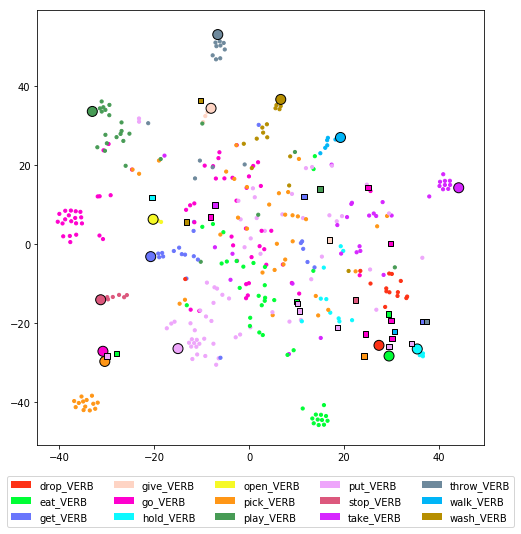

In [74]:
plt.figure(figsize=(8,8))

word_order = sorted(list(set(y_train)))
part_order = sorted(list(set([e.split()[0] for e in meta])))
print(word_order)
print(part_order)
train_end = len(y_train)
dev_end = train_end + len(y_dev)
avg_train_end = dev_end + len(top_words)
avg_dev_end = avg_train_end + len(top_words)

color_by_word = True

L = len(color_lst)

# train words
if color_by_word:
    tr_colors = [color_lst[word_order.index(y)%L] for y in y_train]
    dv_colors = [color_lst[word_order.index(y)%L] for y in y_dev]
else:
    tr_colors = [color_lst[part_order.index(p.split()[0])%L] for p in m_train]
    dv_colors = [color_lst[part_order.index(p.split()[0])%L] for p in m_dev]
    
plt.scatter(red[:train_end, 0], red[:train_end, 1], s=10, color=tr_colors)

# centroids of train words
if color_by_word:
    plt.scatter(red[dev_end:avg_train_end, 0], red[dev_end:avg_train_end, 1], s=100,
            color=[color_lst[word_order.index(y)%L] for y in top_words], linewidth=1, edgecolor='k')

# dev words
plt.scatter(red[train_end:dev_end, 0], red[train_end:dev_end, 1], s=30, color=dv_colors,
            marker='s', linewidth=1, edgecolor='k')

# centroids of dev words
#plt.scatter(red[avg_train_end:, 0], red[avg_train_end:, 1], s=50,
#            color=[color_lst[word_order.index(y)%L] for y in top_words], marker='s', linewidth=1, edgecolor='k')

if color_by_word:
    legend_elements = [Patch(facecolor=color_lst[i%L], label=word_order[i]) for i in range(len(word_order))]
else:
    legend_elements = [Patch(facecolor=color_lst[i%L], label=part_order[i]) for i in range(len(part_order))]
plt.legend(handles=legend_elements, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.2))

plt.savefig("%s/big_scatter.pdf"%figdir, bbox_inches='tight')
plt.show()

In [ ]:
vocab_mat_figures(outpath, 'raw_train', avg_train, top_words, mn, mx, 'png', save=config['LOG'])
vocab_mat_figures(outpath, 'raw_dev', avg_dev, top_words, mn, mx, 'png', save=config['LOG'])
vocab_mat_figures_indv(outpath, train_tup, mn, mx, 'png', save=config['LOG'])
vocab_mat_figures_indv(outpath, dev_tup, mn, mx, 'png', save=config['LOG'])

In [ ]:
for i in range(8):
    print(vocab[i])
    plt.hist([X_train[[i for i,y in enumerate(y_train) if (y == 'pick_VERB') ], i],
         X_train[[i for i,y in enumerate(y_train) if (y == 'put_VERB') ], i]], normed=True)
    plt.show()